In [1]:
import pandas
import io
from zipfile import ZipFile
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pandas.read_csv(io.BytesIO(ZipFile('paravance-71-paravance-72_2018-06-29_1022596.zip').read('exp/exp_Isend.csv')), names = ['op', 'msg_size', 'start', 'duration'])

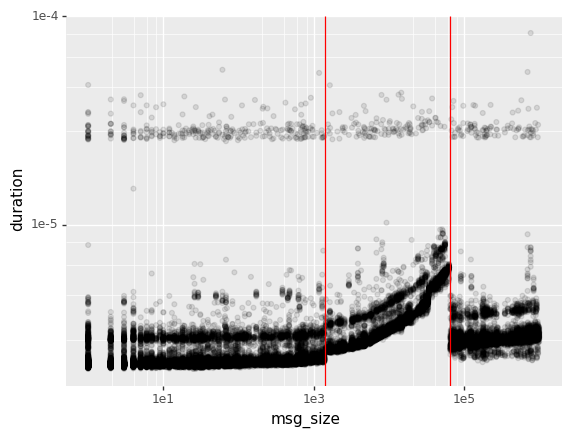

<ggplot: (8769669420990)>

In [2]:
ggplot(df, aes(x='msg_size', y='duration')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + geom_vline(aes(xintercept=1420), color='red') + geom_vline(aes(xintercept=65536), color='red')

In [3]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
x = df.msg_size
y = df.duration

with pm.Model() as sw_model:

    break1 = 1420
    break2 = 65536
    coeff_array = pm.Normal('coeff_array', 0, sd=1, shape=3)
    intercept_array = pm.Normal('intercept_array', 0, sd=1, shape=3)
    sigma = pm.HalfNormal('sigma', sd=1)

    intercept = pm.math.switch(x < break1, intercept_array[0], pm.math.switch(x < break2, intercept_array[1], intercept_array[2]))
    coeff     = pm.math.switch(x < break1, coeff_array[0],     pm.math.switch(x < break2, coeff_array[1], coeff_array[2]))

    likelihood = pm.Normal('y', mu=intercept + coeff * x, sd=sigma, observed=y)

    start = pm.find_MAP() 

    step1 = pm.NUTS([coeff_array, intercept_array])

    trace = pm.sample(2000, step=[step1], start=start, njobs=4,progressbar=True)

logp = -22,949, ||grad|| = 35,133: 100%|██████████| 5/5 [00:00<00:00, 521.11it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept_array, coeff_array]
>NUTS: [sigma]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:54<00:00, 15.99draws/s]
The acceptance probability does not match the target. It is 0.9408503745499658, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.943604425277471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9910448824858125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9813173535550719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9911624535070577, but should be close to 0.8. Try to increase th

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d73b7d3c8>,
      dtype=object)

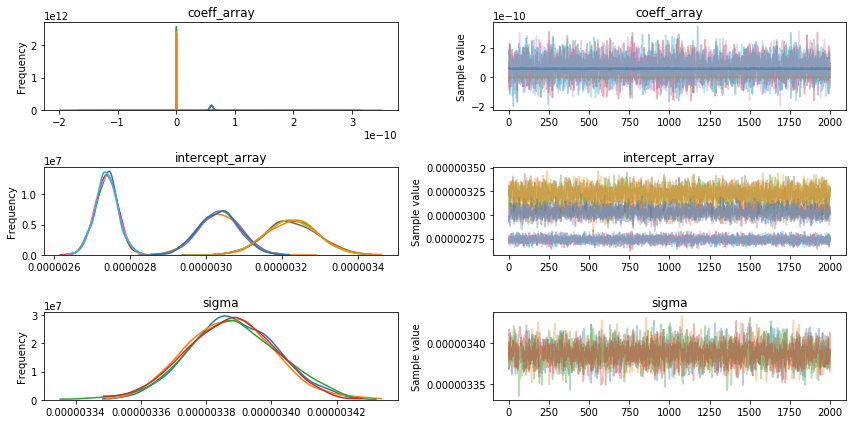

In [5]:
pm.traceplot(trace)

In [6]:
reg = pm.summary(trace)
reg

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
coeff_array__0,6.670323e-11,7.488929e-11,9.027591e-13,-8.213945e-11,2.111238e-10,5723.355876,1.000076
coeff_array__1,6.010192e-11,2.537314e-12,4.216166e-14,5.501165e-11,6.495010e-11,3608.430183,1.000423
coeff_array__2,3.669816e-13,1.604101e-13,2.538284e-15,5.076932e-14,6.799738e-13,3617.593261,1.000839
intercept_array__0,2.738471e-06,2.984468e-08,3.844225e-10,2.677109e-06,2.795304e-06,5598.108507,0.999764
intercept_array__1,3.034687e-06,5.443486e-08,9.637629e-10,2.929794e-06,3.141011e-06,3668.729490,1.000629
intercept_array__2,3.226105e-06,6.814021e-08,1.069459e-09,3.095507e-06,3.362163e-06,3731.334162,1.000277
sigma,3.387749e-06,1.352478e-08,3.135500e-10,3.362282e-06,3.415189e-06,2087.717888,1.000742


In [7]:
import numpy
def plot_reg(df, reg, groups):
    plot = ggplot(df, aes(x='msg_size', y='duration')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10()
    for coeff_name, inter_name, x_min, x_max in groups:
        coeff = reg.loc[coeff_name]['mean']
        inter = reg.loc[inter_name]['mean']
        x = numpy.random.uniform(x_min, x_max, 100)
        y = x*coeff + inter
        plot += geom_line(pandas.DataFrame(dict(x=x, y=y)), aes(x=x, y=y), color='red')
    return plot

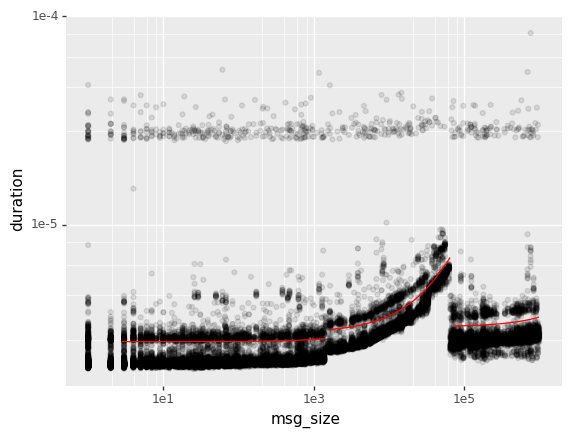

<ggplot: (-9223363267209366086)>

In [8]:
groups = [
    ('coeff_array__0', 'intercept_array__0', 0, 1420),
    ('coeff_array__1', 'intercept_array__1', 1420, 65536),
    ('coeff_array__2', 'intercept_array__2', 65536, df.msg_size.max()),
]
plot_reg(df, reg, groups)